A while ago (in december) I had a meeting with stephen, these were some points raised
1. (done) Better reject high spurious center of mass values. The discrimination criterion should be based on a minimum number
of significant bins for the dprime based on a chance cutout
2. Do most of the analysis should on cell-probe pairs (use id_probe in DF)
3. are contextual effects independent of  probe?? if for one probe there are contextual effects, is there expected that
they also exist for other probes?
4 for the region comparisons, do them independently for each transition pair, as pooling across all of them might be
averaging out the effects, when there is no significant contextual effects.
5. conversely, for comparison of the effects of context transitions, further discriminate based on region
6. For a probe, display differences between context with a node-edge graph.


In [31]:
import itertools as itt
from pathlib import Path
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

from src.data.region_map import region_map
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes_v2 import single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.consolidated_metrics import _append_means_to_array, metrics_to_DF, _append_means_to_shuff_array
from src.metrics.significance import _significance, _mask_with_significance

In [2]:


plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

In [3]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [8]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path('../data/210302_consolidated_summary_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
DF['id'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id', 'probe']].agg('_'.join, axis=1)

DF = DF.drop(columns=['cellid', 'siteid'])

print('duplicated columns?: ', any(DF.loc[:,[col for col in DF.columns if col !='value']].duplicated()))

duplicated columns?:  False


## parameter space scaterplots
### for context and probe means

In [12]:
DF.mult_comp_corr.unique()

array(['none', 'full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
      dtype=object)

False


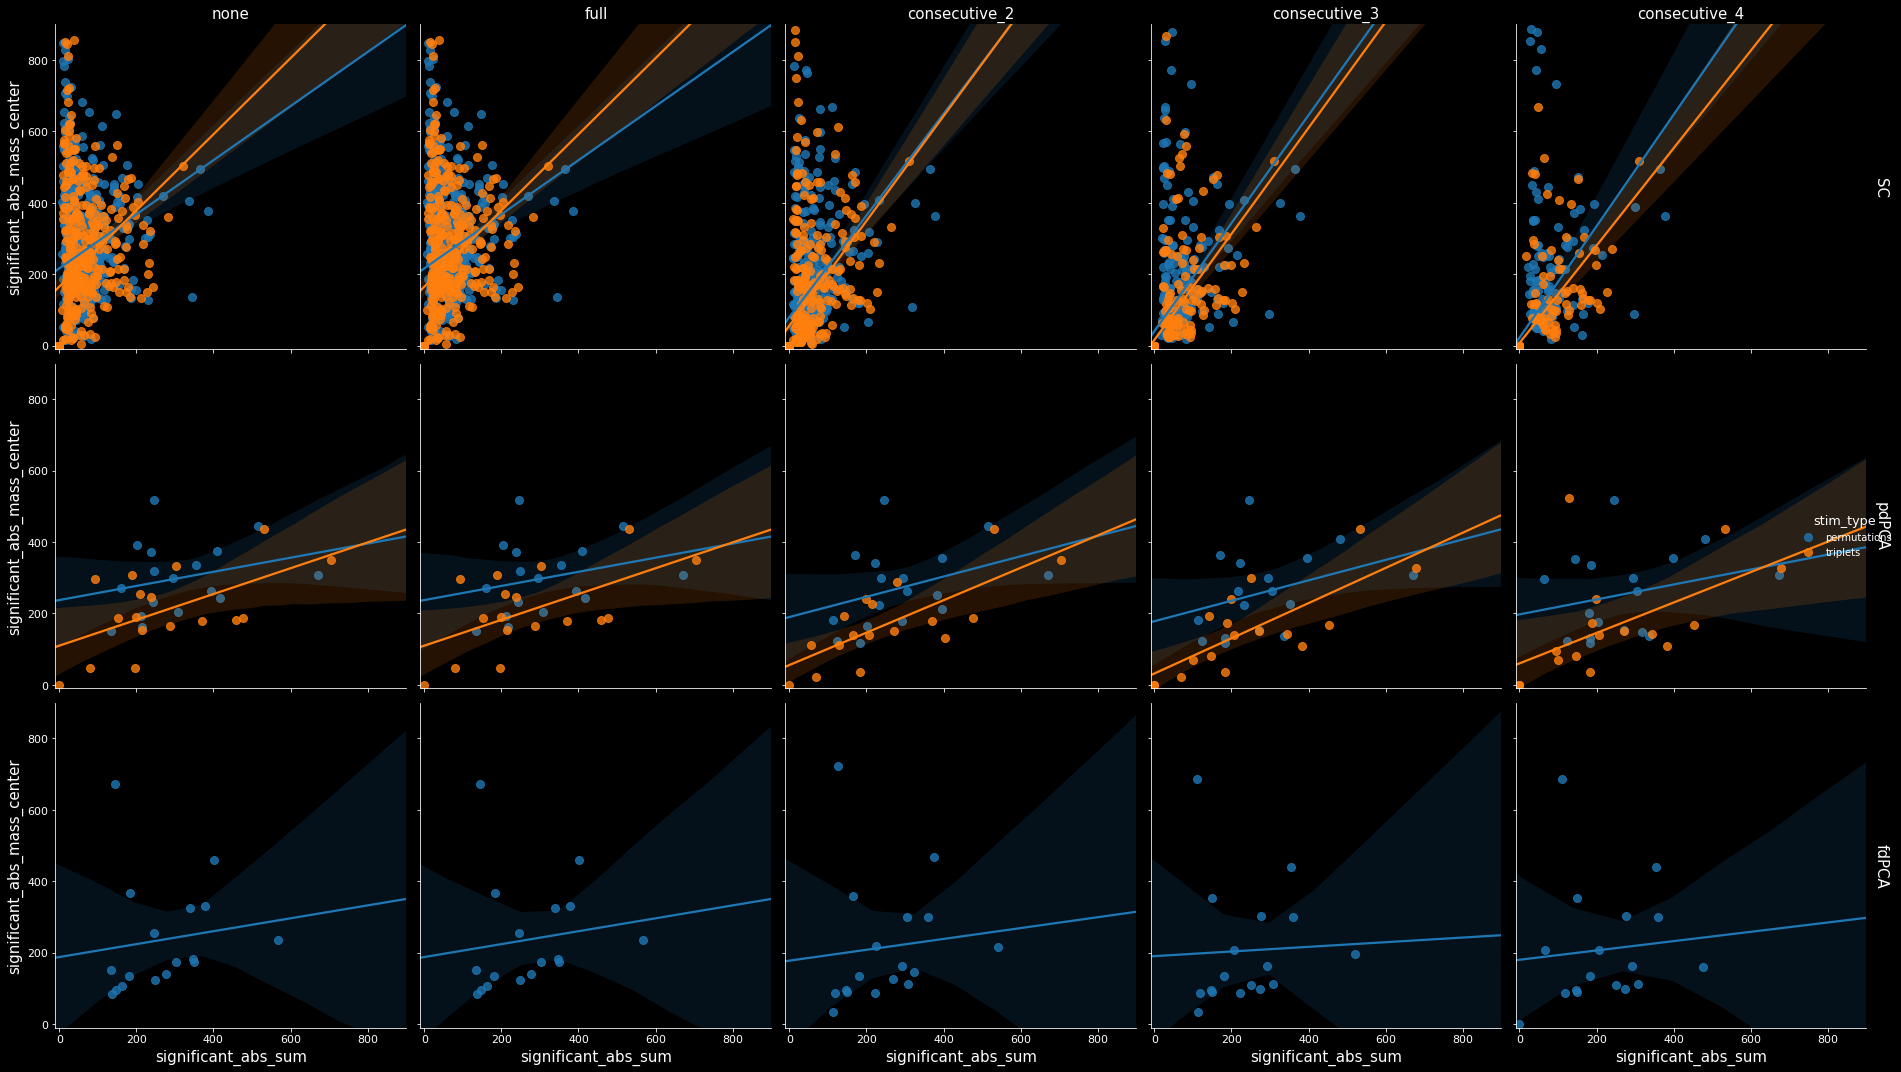

In [15]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'id_probe', 'probe', 'context_pair', 'region`']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
# print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot,
               row='analysis', col='mult_comp_corr', hue='stim_type',
               row_order=['SC', 'pdPCA', 'fdPCA'], col_order=['none', 'full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
               sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,900)
ax.set_ylim(-10,900)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")



### same as before but for id_probes

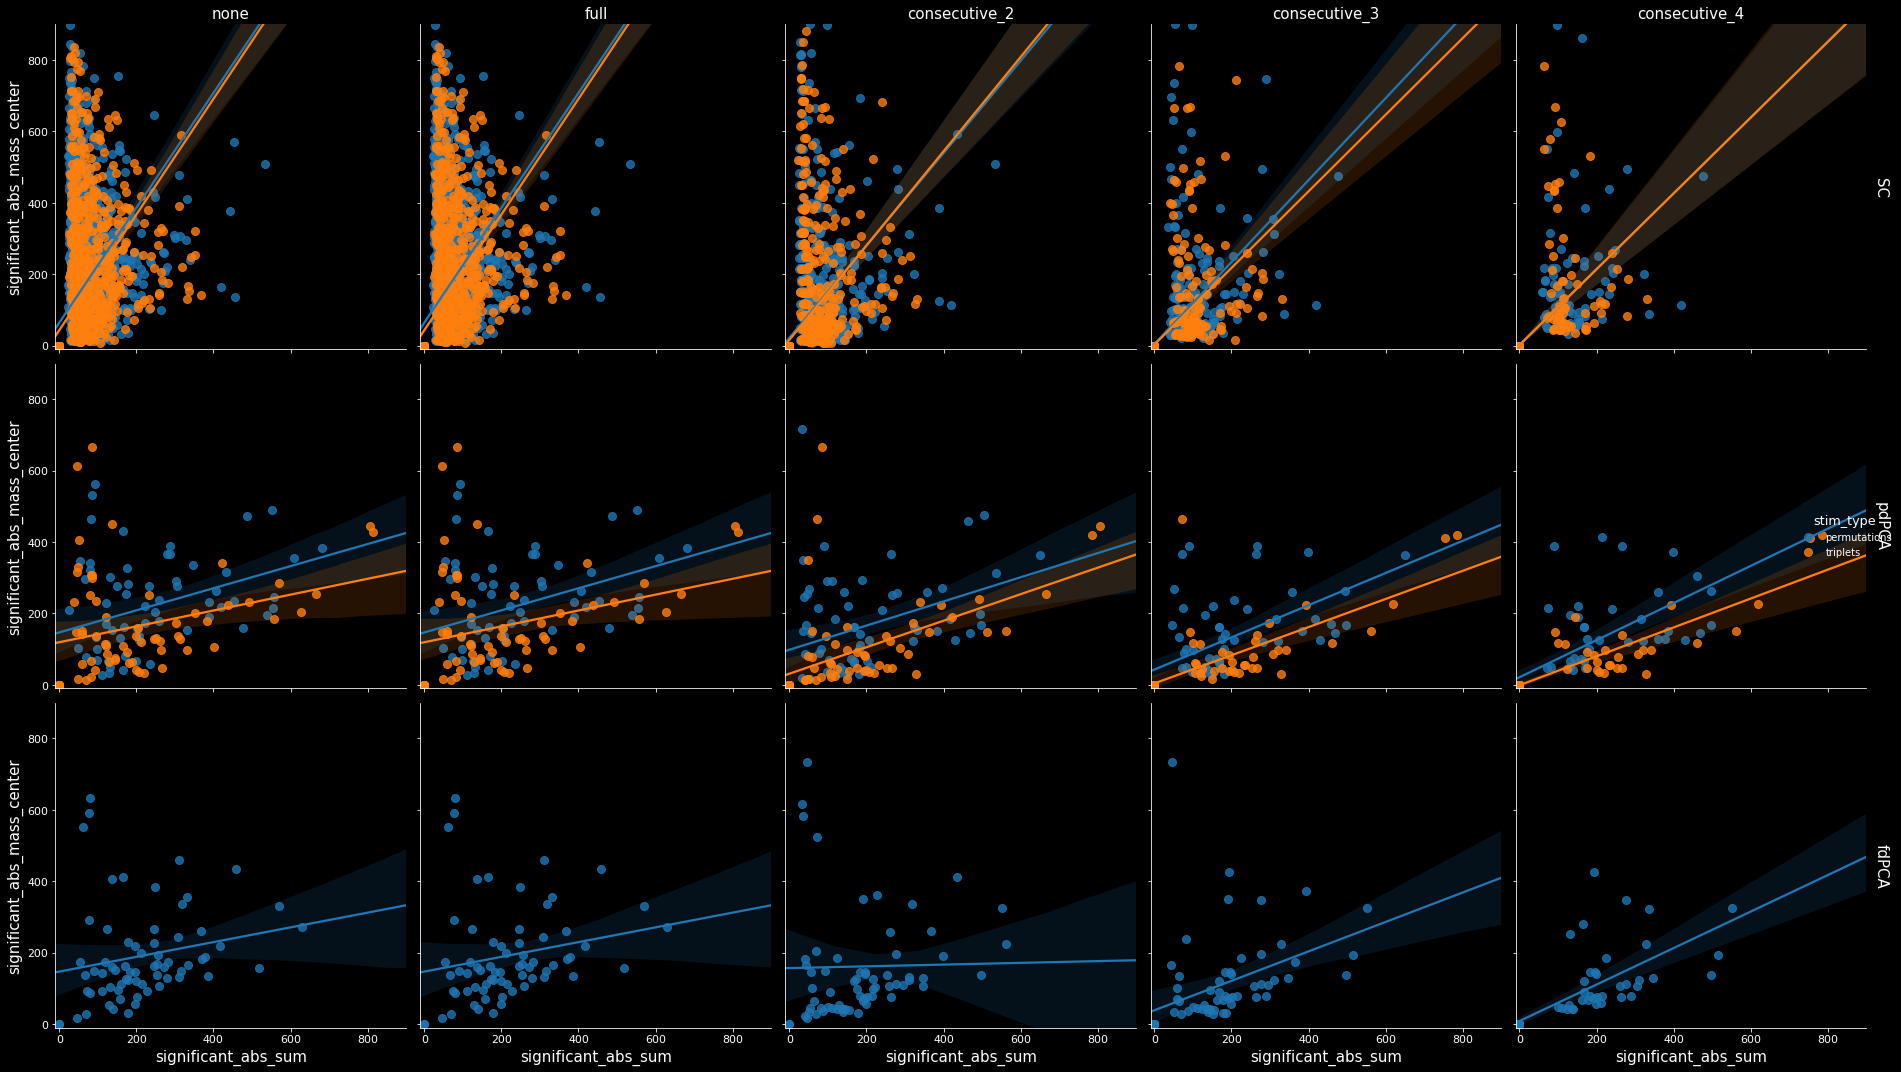

In [16]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe != 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'probe', 'context_pair', 'id', 'region']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
# print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot,
               row='analysis', col='mult_comp_corr', hue='stim_type',
               row_order=['SC', 'pdPCA', 'fdPCA'], col_order=['none', 'full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
               sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,900)
ax.set_ylim(-10,900)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


Its unexpected to see such a late single cell significances with consecutive_4 correction.

what are those outliers?:

In [27]:
# get some outlierse for SC and dPCA with low integral and high center of mass

ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
ff_analysis = DF.analysis.isin(['SC', 'pdPCA', 'fdPCA'])
ff_correction = DF.mult_comp_corr == 'consecutive_4'
ff_stim = DF.stim_type == 'permutations'


goodcols = [col for col in DF.columns if col not in ['value', 'metric', 'id_probe', 'context_pair', 'probe']]
filtered = DF.loc[ff_ctx & ff_prb & ff_analysis & ff_stim & ff_correction,:]
# print(any(filtered.loc[:, [col for col in filtered.columns if col !='value']].duplicated()))
pivoted = filtered.pivot_table(index=goodcols, columns='metric', values='value', aggfunc='first').reset_index()
sorted = pivoted.sort_values(['significant_abs_mass_center', 'significant_abs_sum'], axis=0, ascending=[0,1])
sorted
print(sorted.head(10))

metric mult_comp_corr     stim_type analysis region            id  \
183     consecutive_4  permutations       SC     A1  CRD018d-39-3   
385     consecutive_4  permutations       SC    PEG  CRD011c-30-3   
233     consecutive_4  permutations       SC     A1  ley072b-11-1   
86      consecutive_4  permutations       SC     A1  CRD003b-03-1   
332     consecutive_4  permutations       SC    PEG  AMT030a-09-4   
328     consecutive_4  permutations       SC    PEG  AMT030a-03-2   
441     consecutive_4  permutations    fdPCA     A1       ley075b   
458     consecutive_4  permutations    pdPCA     A1       ley075b   
410     consecutive_4  permutations       SC    PEG  CRD012b-13-1   
335     consecutive_4  permutations       SC    PEG  AMT030a-17-1   

metric  significant_abs_mass_center  significant_abs_sum  
183                      886.101367            30.572017  
385                      878.324643            46.214858  
233                      853.634316            27.096024  
86  

there are plenty of culprits for single cell, and a couple for dPCA:
* fdPCA, ley075b
* pdPCA, ley075b
* SC, CRD018d-39-3
* SC, CRD011c-30-3

It is worth plotting the raw dprime traces and perhaps thinking a new significance correction... at least the function
already exists and should be easy to exted.

In [34]:

def plot_signif_summary(site, cellid, expt_name, fname, corr_name, context_pair=None, probe=None):
    alpha=0.01
    meta = {'reliability': 0.1,  # r value
            'smoothing_window': 0,  # ms
            'raster_fs': 30,
            'montecarlo': 1000,
            'zscore': True,
            'dprime_absolute': None}

    analysis_functions = {'SC': single_cell_dprimes,'LDA':probewise_LDA_dprimes,
                          'pdPCA': probewise_dPCA_dprimes, 'fdPCA': full_dPCA_dprimes}


    permutations = {'contexts': [0, 1, 2, 3, 4],
                    'probes': [1, 2, 3, 4],
                    'stim_type': 'permutations'}

    triplets = {'contexts': ['silence', 'continuous', 'similar', 'sharp'],
                'probes':[2, 3, 5, 6],
                'stim_type': 'triplets'}

    experiments = {'permutations':permutations, 'triplets':triplets}

    multiple_corrections = {'none': (None, None),
                            'full': ([1,2,3], None),
                            'time': ([3], None),
                            'probe': ([2,3], None),
                            'context_pair': ([1,3], None),
                            'consecutive_2': ([3], 2),
                            'consecutive_3': ([3], 3),
                            'consecutive_4': ([3], 4)}



    expt = experiments[expt_name]
    func = analysis_functions[fname]
    corr, cons = multiple_corrections[corr_name]


    # skips full_dPCA for the triplets experiment
    if expt['stim_type'] == 'triplets' and fname == 'fdPCA':
        print('invalid combination.  Triplets cant use fdPCA')

    print(site, expt['stim_type'], fname)

    # parses the stim_type from the experiment into the meta parameters
    expt = expt.copy()
    meta['stim_type'] = expt.pop('stim_type')

    # runs the dprime function
    dprime, shuffled_dprime, goodcells, var_capt = func(site, **expt, meta=meta)

    # for analysis with dimensionality reduction, changes the cellname to nan for proper dimension labeling.
    if fname != 'SC':
        chan_name = [np.nan]
        cell = 0
    else:
        chan_name = goodcells
        cell = goodcells.index(cellid)

    # creates label dictionalry
    dim_lab_dict = {'cellid': chan_name,
                    'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(expt['contexts'], 2)],
                    'probe': expt['probes'],
                    'time': np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                        endpoint=False) * 1000}

    # calculates different significaces/corrections
    # calculate significant time bins, both raw and corrected for multiple comparisons

    significance, confidence_interval = _significance(dprime, shuffled_dprime, corr, cons, alpha=alpha)
    fliped, fliped_shuffled = flip_dprimes(dprime, shuffled_dprime, flip='sum')

    # only time correction for the means

    dprime_means, _  = _append_means_to_array(fliped, dim_lab_dict)
    shuff_means, _  = _append_means_to_shuff_array(fliped_shuffled, dim_lab_dict)

    raw_signif, _ = _significance(dprime_means, shuff_means, None, None, alpha)
    shuf_signif, shuf_CI = _significance(dprime_means, shuff_means, [3], cons, alpha=alpha)

    # masks dprime with different significances, uses different approaches to define significance of the mean.
    masked, masked_lab_dict = _mask_with_significance(fliped, significance, dim_lab_dict, mean_type='shuffles',
                                                      mean_signif_arr=shuf_signif)
    corr_signif = ~masked.mask


    CI = shuf_CI.copy()
    CI[:,:,:-1,:-1,:] = confidence_interval

    # calculate different metrics and organize into a dataframe
    df = metrics_to_DF(masked, masked_lab_dict, metrics=['significant_abs_mass_center', 'significant_abs_sum'])

    t = dim_lab_dict['time']

    bar_bottom = -0.5
    bar_width = 1000/30

    # plots all context probes and means
    if (context_pair is None) and (probe is None):
        fig, axes = plt.subplots(len(masked_lab_dict['probe']), len(masked_lab_dict['context_pair']),
                                 sharex='all', sharey='all', figsize=(20,10))
        for (tt, trans_pair),(pp, probe) in itt.product(enumerate(masked_lab_dict['context_pair']),
                                                        enumerate(masked_lab_dict['probe'])):

            ax = axes[pp,tt]
            _ = ax.plot(t, dprime_means[cell, tt, pp, :], color='white', label='dprime')

            _ = ax.fill_between(t, CI[0, cell, tt, pp, :], CI[1,cell, tt, pp, :],
                            color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

            _ = ax.bar(t, raw_signif[cell, tt, pp, :], width=bar_width, align='center', color='purple',
                   edgecolor='white', bottom=bar_bottom, alpha=0.5, label='raw_signif')

            _ = ax.bar(t, corr_signif[cell, tt, pp, :], width=bar_width, align='center', color='green',
                   edgecolor='white', bottom=bar_bottom+bar_bottom, alpha=0.5, label='corr_signif')

        # _ = ax.legend()

    # plots specific context and probe
    elif (context_pair is not None) and (probe is not None):
        fig, ax = plt.subplots()
        _ = ax.plot(t, dprime_means[cell, context_pair, probe, :], color='white', label='dprime')


        _ = ax.fill_between(t, CI[0, cell, context_pair, probe, :], CI[1,cell, context_pair, probe, :],
                        color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

        ax_bott = -0.5
        _ = ax.bar(t, raw_signif[cell, context_pair, probe, :], width=bar_width, align='center', color='purple',
               edgecolor='white', bottom=ax_bott, alpha=0.5, label='raw_signif')

        _ = ax.bar(t, corr_signif[cell, context_pair, probe, :], width=bar_width, align='center', color='green',
               edgecolor='white', bottom=ax_bott+ax_bott, alpha=0.5, label='corr_signif')

        _ = ax.legend()

    return fig, df

CRD018d permutations SC


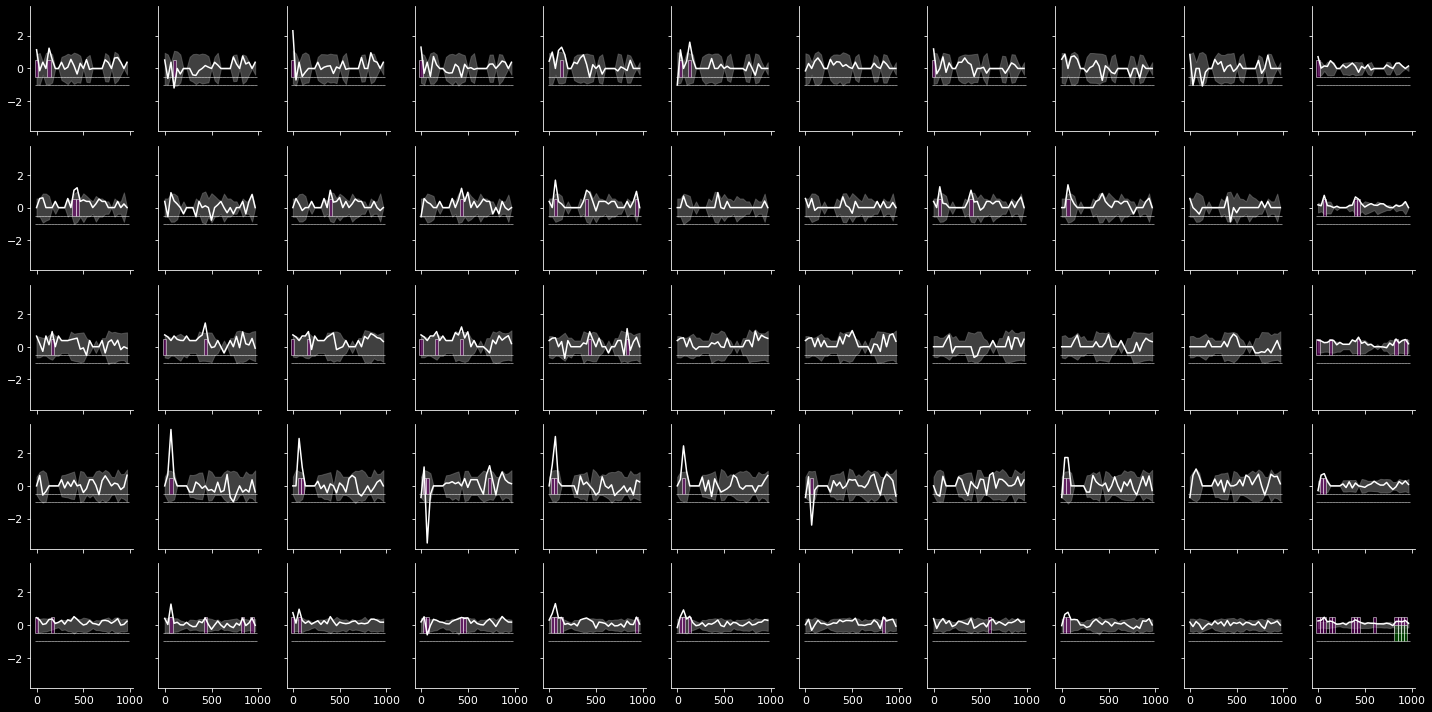

In [40]:
cellid = 'CRD018d-39-3'
site = 'CRD018d'
expt_name = 'permutations'
fname = 'SC'
mult_corr = 'consecutive_4'
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=None, probe=None)

CRD018d permutations SC


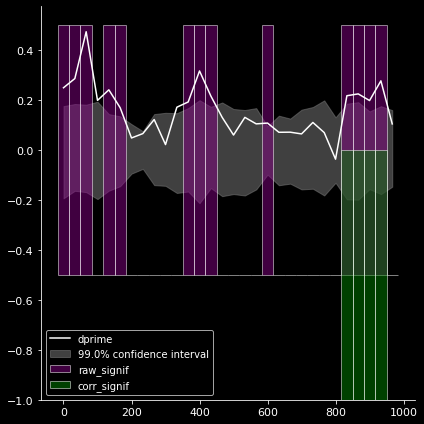

In [37]:
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=10, probe=4)

CRD011c permutations SC


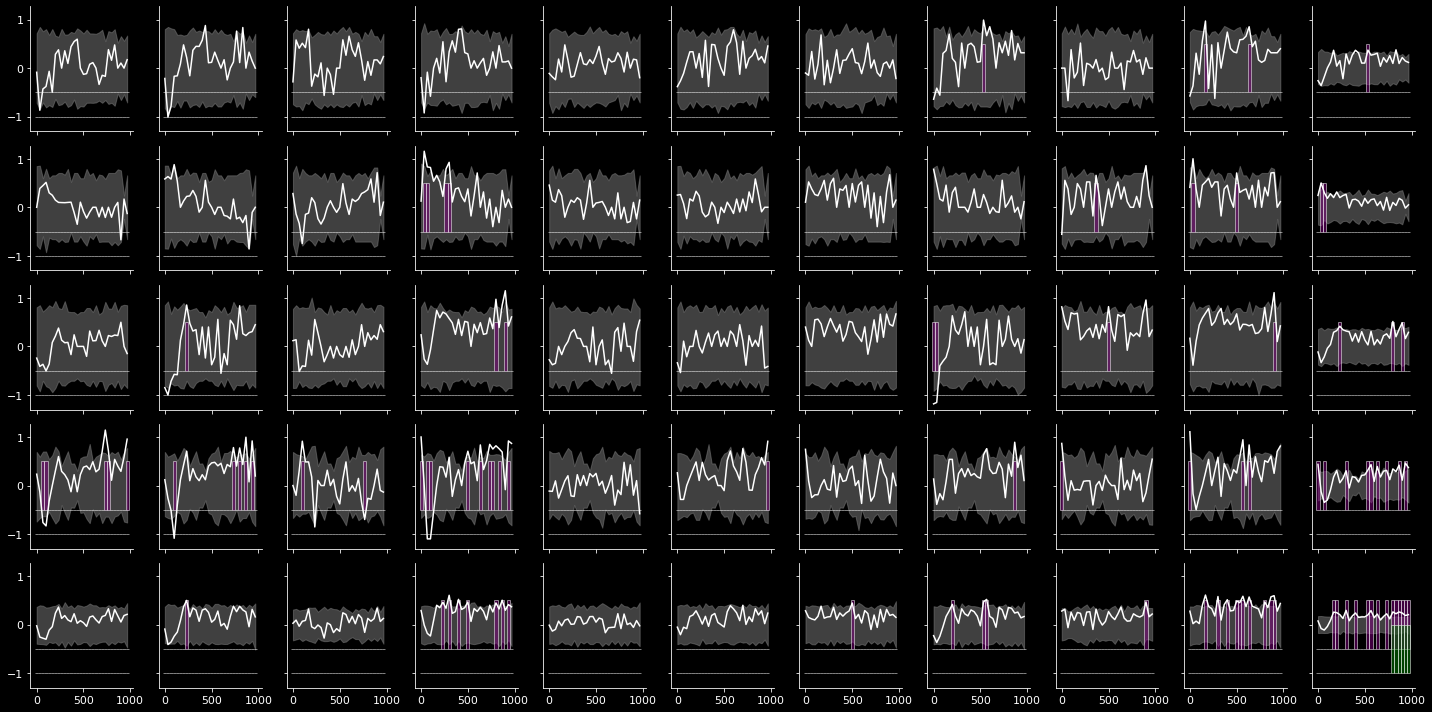

In [42]:
cellid = 'CRD011c-30-3'
site = 'CRD011c'
expt_name = 'permutations'
fname = 'SC'
mult_corr = 'consecutive_4'
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=None, probe=None)

CRD011c permutations SC


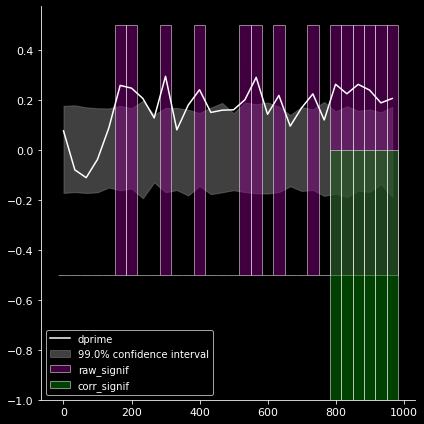

In [44]:
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=10, probe=4)

ley075b permutations pdPCA


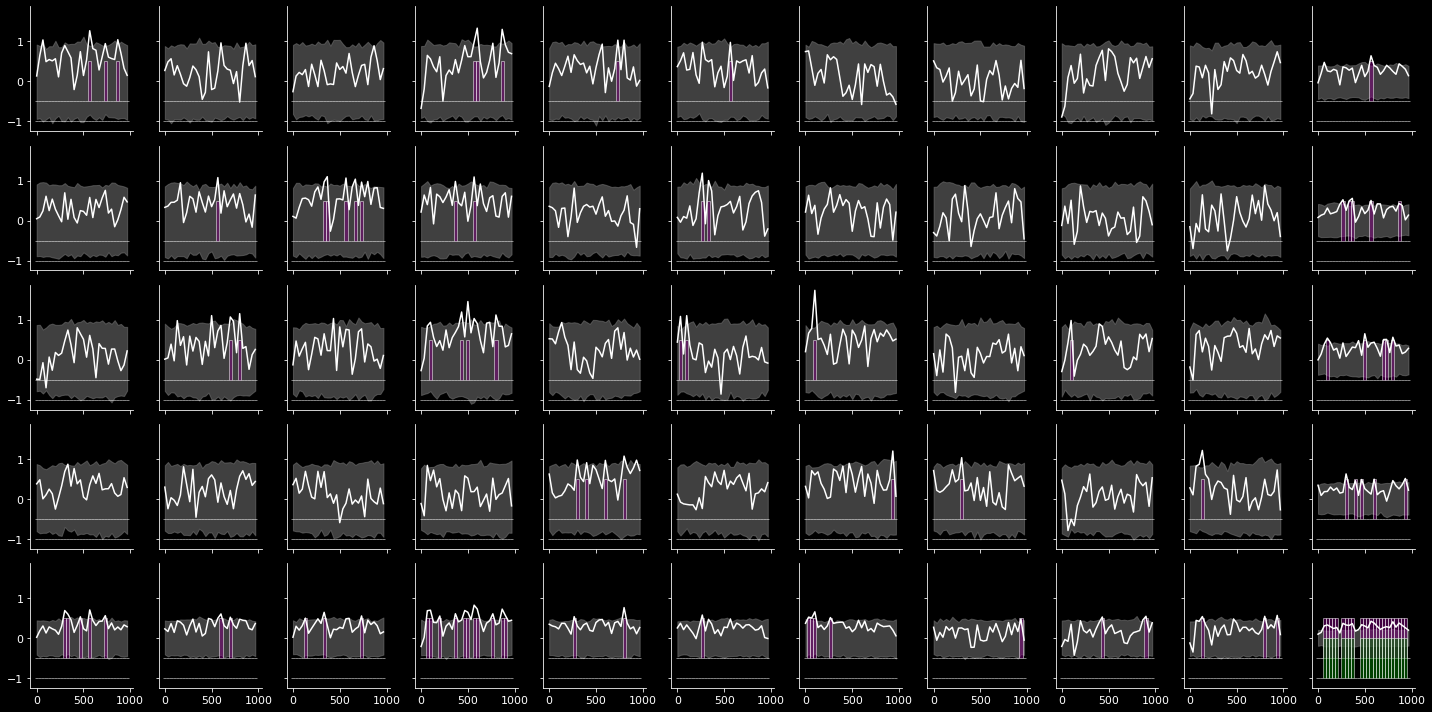

In [45]:
cellid = None
site = 'ley075b'
expt_name = 'permutations'
fname = 'pdPCA'
mult_corr = 'consecutive_4'
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=None, probe=None)

ley075b permutations pdPCA


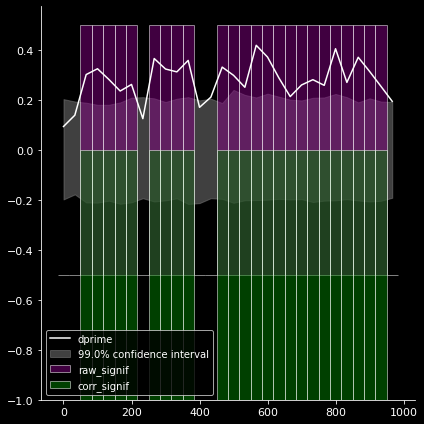

In [46]:
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=10, probe=4)

ley075b permutations fdPCA


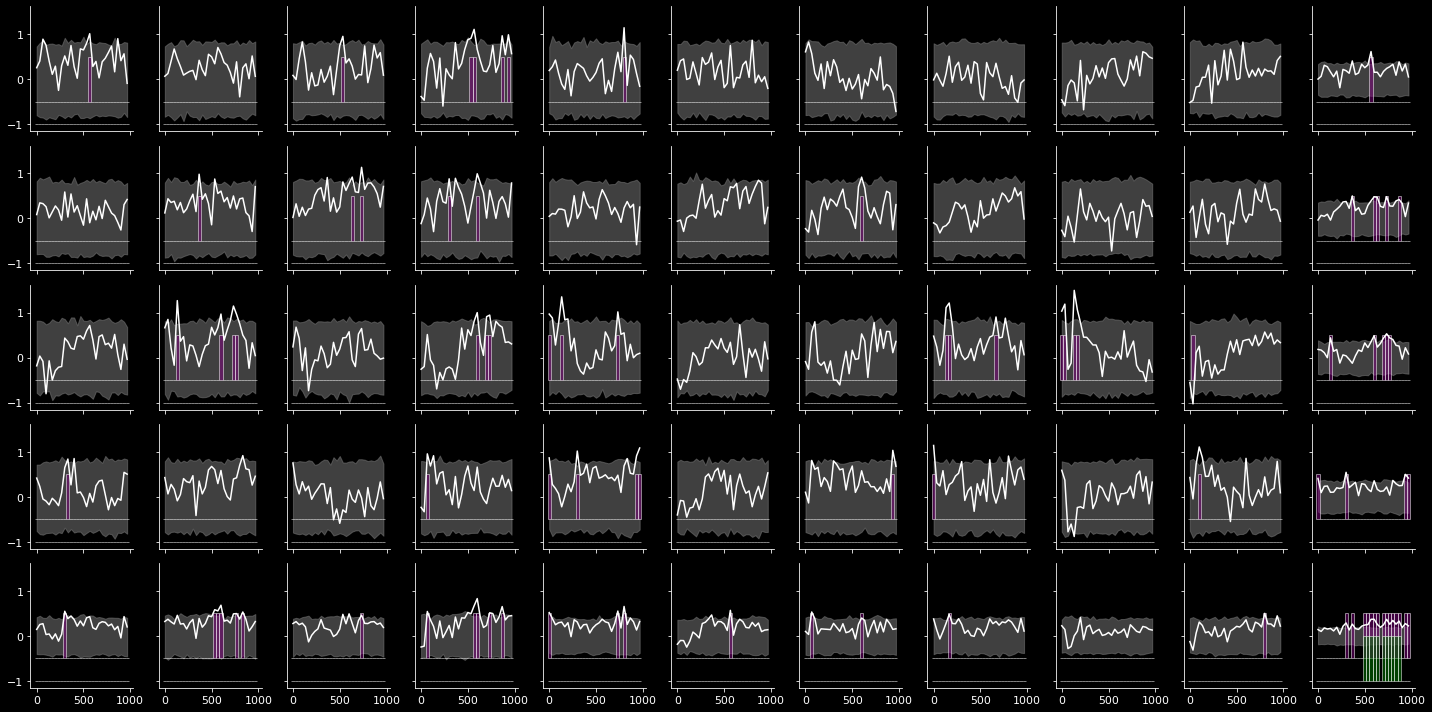

In [47]:
fname = 'fdPCA'
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=None, probe=None)

ley075b permutations fdPCA


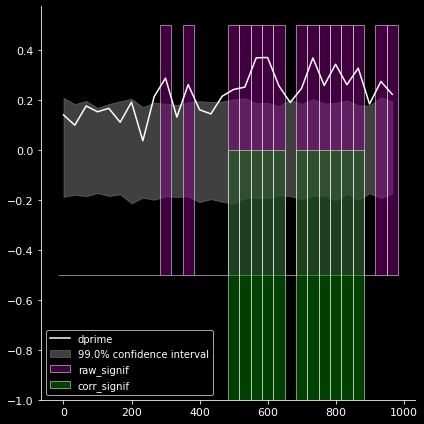

In [48]:
fig, df  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, context_pair=10, probe=4)